## Data Wrangling

In [2]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas

### Create and Verify Database

In [3]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [4]:
ingest_create_athena_db_passed = False

In [5]:
# Set db name
database_name = "crops"

In [6]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [8]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [9]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default


In [10]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [11]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [15]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [12]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


# Exploratory Data Analysis

In [13]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
1,Albania,Apricots,1991,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
2,Albania,Barley,1991,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
3,Albania,Beans dry,1991,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
4,Albania,Broad beans and horse beans green,1991,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN


In [14]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 429254 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [15]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="geoapiExercise")
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [16]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [17]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
0,Albania,Apples,1991,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
1,Albania,Apricots,1991,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
2,Albania,Barley,1991,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
3,Albania,Beans dry,1991,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
4,Albania,Broad beans and horse beans green,1991,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962


## NA Analysis

In [18]:
nan_count = df.isna().sum()
print(nan_count)

area                    0
item                    0
year                    0
production           4966
nitrogen             3422
phosphate            5786
potassium            6927
value              142337
avg_rain                0
avg_temp                0
total_value_usd    142793
lat                     0
long                    0
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

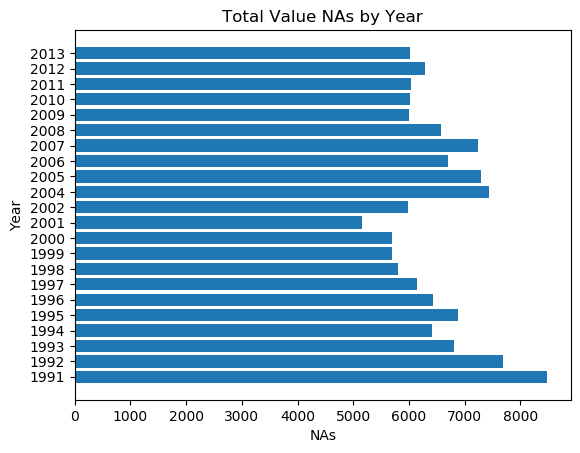

In [19]:
# By Year
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year['year'] = na_year['year'].astype(object)

bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

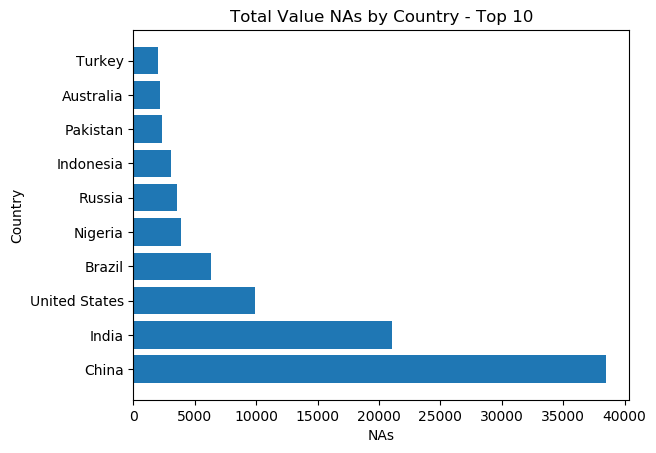

In [20]:
# By Country
na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [21]:
df_nona = df.dropna()
df_nona_china = df_nona[df_nona['area'] == "China"]
df_china = df[df['area'] == "China"]

print("China loses", df_china.shape[0] - df_nona_china.shape[0], "observations when we take out NAs leaving us with", df_nona_china.shape[0], "observations left for the country")

China loses 38466 observations when we take out NAs leaving us with 44316 observations left for the country


### Final clean before modeling 
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those. We also should not need production, value, or year for our final modeling (not doing time series) so we'll create another modeling dataframe here.

In [32]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            176
phosphate          1422
potassium          1668
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                   0
long                  0
dtype: int64


In [23]:
df_model = df_clean.drop(columns = ['year', 'production', 'value'], axis = 1)

## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

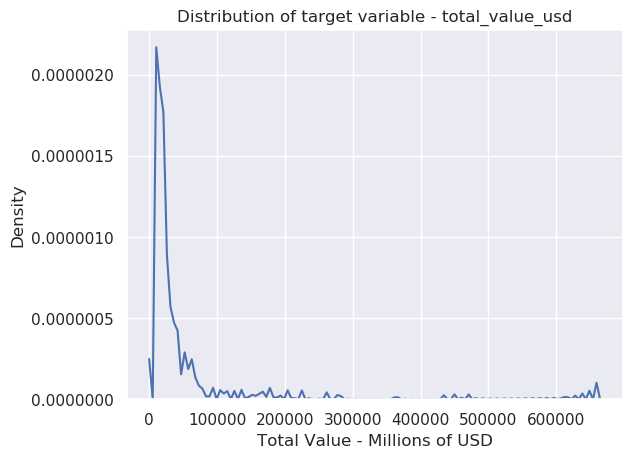

In [24]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

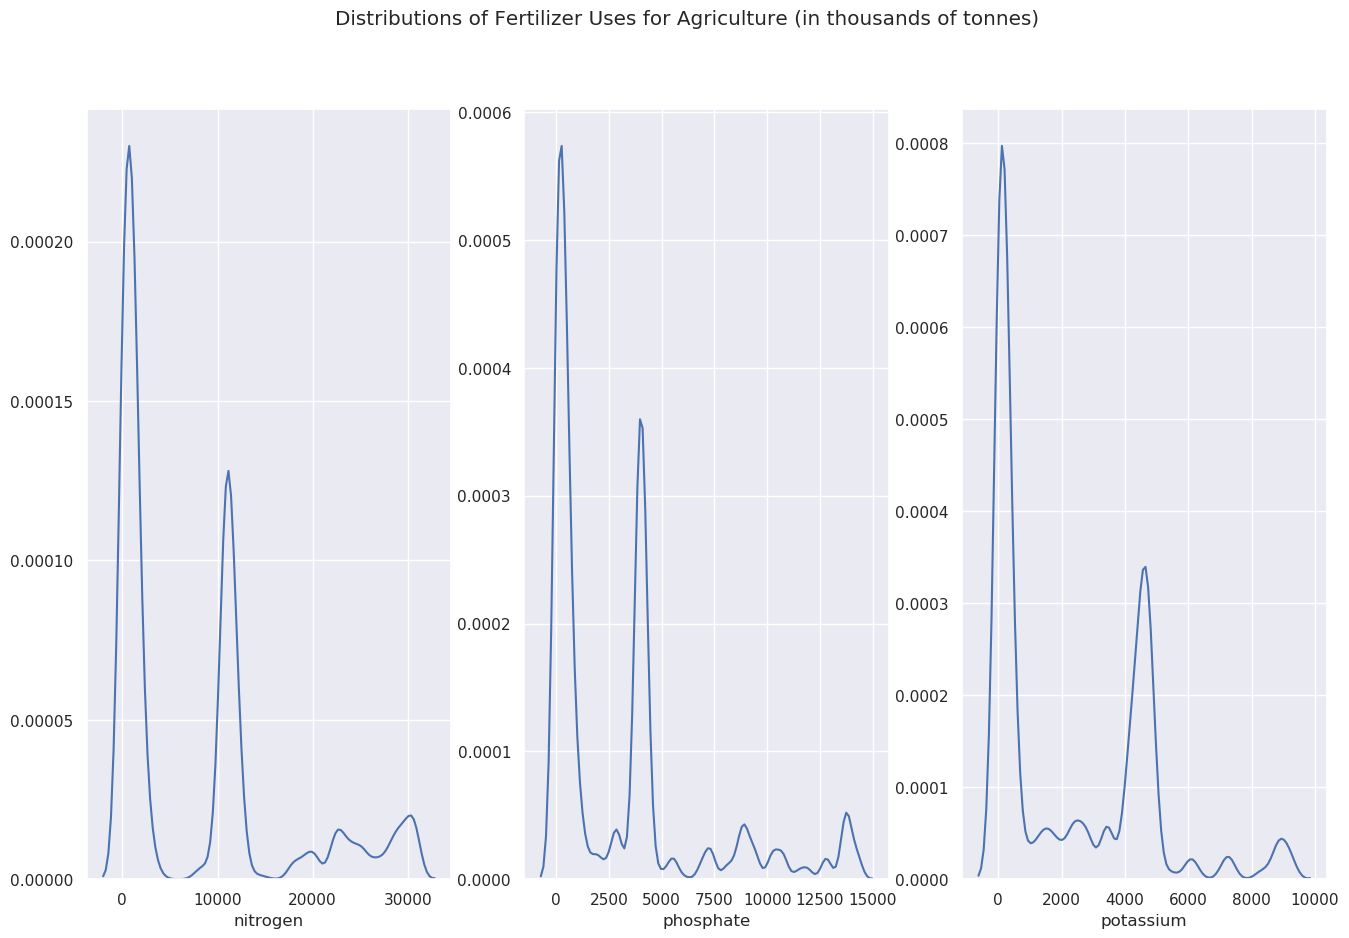

In [25]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

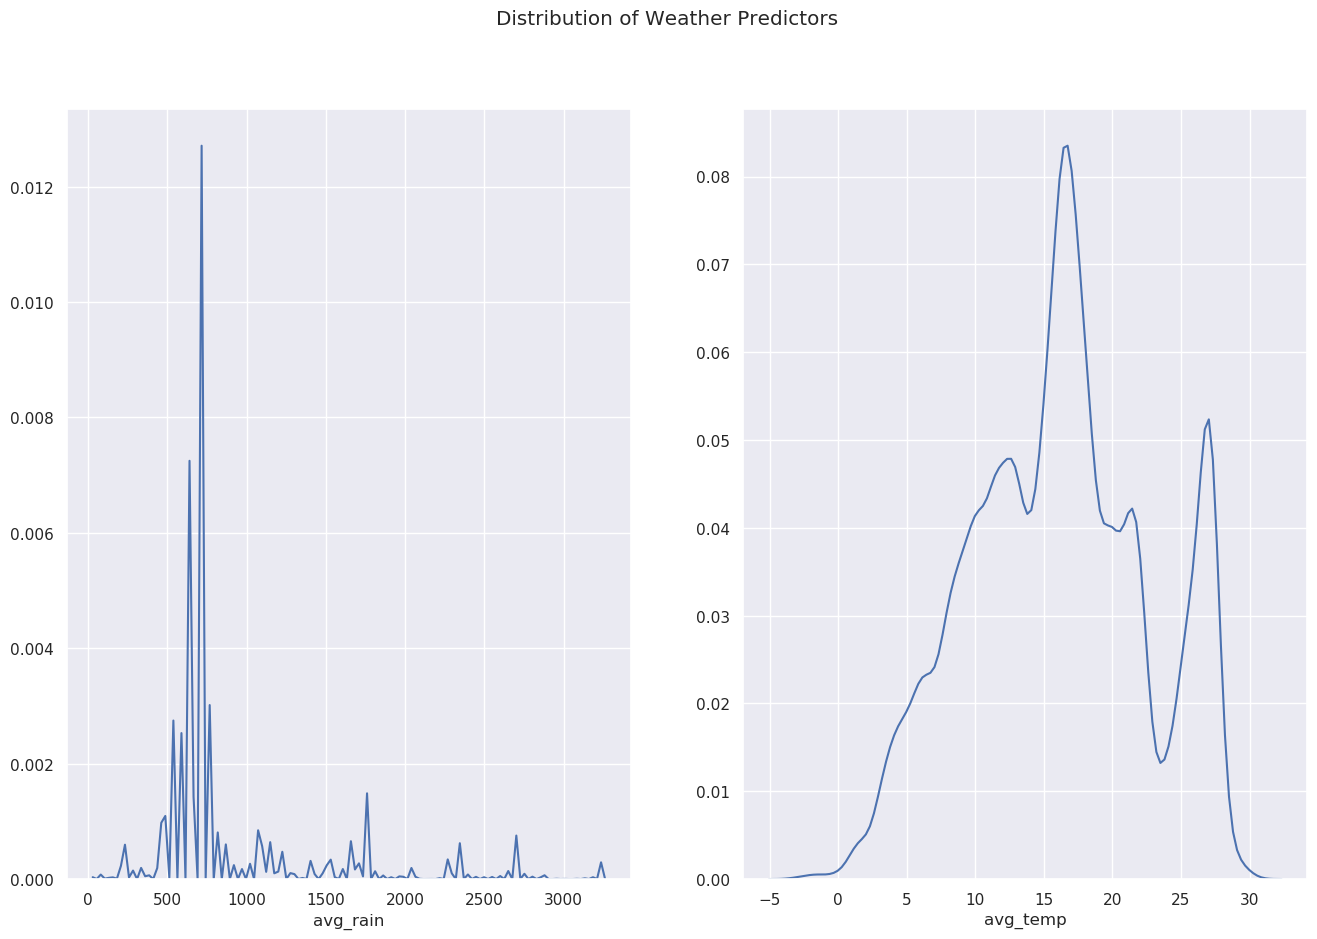

In [26]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

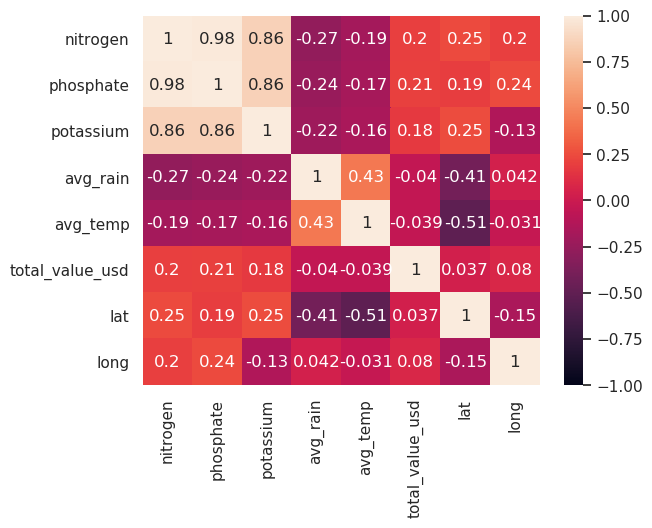

In [27]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [28]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#### Fix Country names:
Some names aren't matching between world and df, need to match them since we're merging on them.

In [29]:
world['name'].unique();

In [30]:
world_country = ['United States of America', 'Dem. Rep. Congo', 'Congo']
df_country = ["United States", "Congo, Dem. Rep.", "Congo, Rep."]

world2 = world

for (old, new) in zip(world_country, df_country):
    world2['name'] = world['name'].replace(old,new)



### Highest Ag Value 1991-2013

In [34]:
val_country = df_clean.groupby(by="area")["total_value_usd"].sum()

countries = df_clean['area'].unique()
countries = pd.Series(countries)

geos = world2[['name', 'geometry']]
geos

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

gdf_value.head()


,country,value,geometry
0,Albania,4.868495e+10,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
1,Algeria,2.760152e+11,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948..."
2,Angola,3.040496e+10,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,Argentina,1.023883e+12,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
4,Armenia,3.370657e+10,"POLYGON ((46.50572 38.77061, 46.14362 38.74120..."


In [ ]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

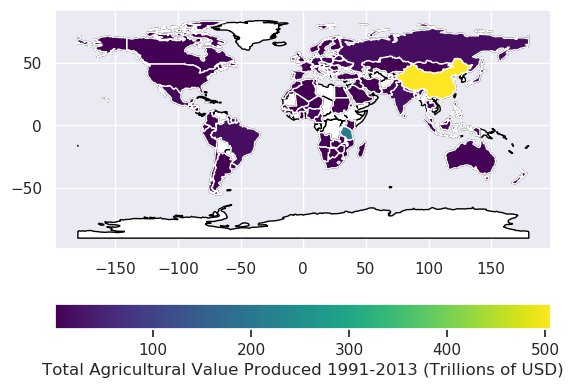

In [ ]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()



### Avg. Temperatures

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

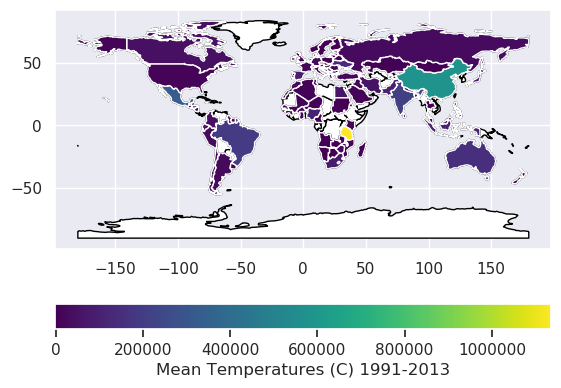

In [37]:
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_temp"].sum()


val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

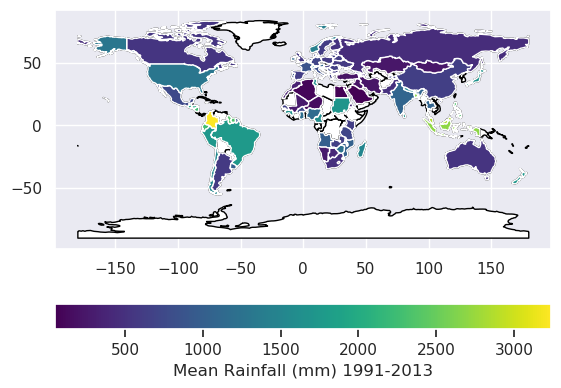

In [40]:
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_rain"].mean()

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [43]:
val_country = df_clean.groupby(by="area")["nitrogen"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [44]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

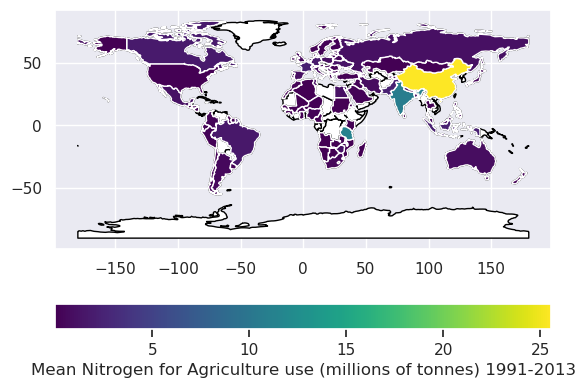

In [45]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Phosphate

In [48]:
val_country = df_clean.groupby(by="area")["phosphate"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [49]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

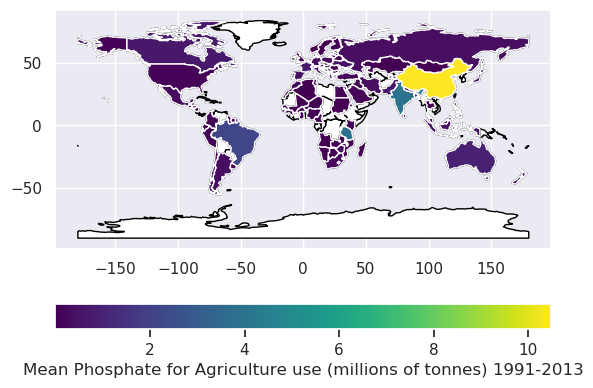

In [50]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [51]:
val_country = df_clean.groupby(by="area")["potassium"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [52]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>

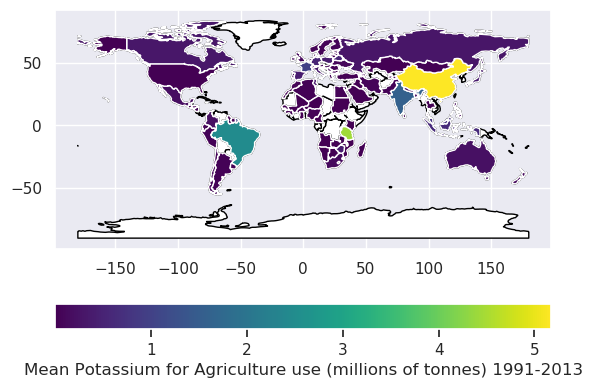

In [53]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [ ]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])
cat_df.head()

### "area" EDA:

In [ ]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

In [ ]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


#### Might be useful to create a reference dataframe/table for the areas column:

In [ ]:
countries_df = pd.DataFrame(cat_df['area'].unique())

countries_df.head()

In [ ]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', figsize=(20,10), title= 'Top 10 Countries With Most Rows of Data', xlabel='Count', ylabel='Country', color = 'teal')
plt.show()

#### Countries with most rows of data include India, Mexico, Brazil & Australia

In [ ]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().astype(int).reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)

p_country

p_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), xlabel='Production Count', ylabel='Country', color = 'teal')
plt.show()


#### countries with most production are India, Brazil, Indonesia, and Mexico

In [ ]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().astype(int).reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country.head()

usd_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), xlabel='Total Value (USD)', ylabel='Country', color = 'teal')
plt.show()


#### Countries with highest total value USD include India, Brazil, Japan, Mexico. 

### "Item" EDA

In [ ]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different produce items in the dataset")

In [ ]:
#examining unique to view different item types that are in the dataset
items = pd.DataFrame(cat_df['item'].unique())
items.head()

In [ ]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', figsize=(20,10), title= 'Top 10 Items With Most Rows of Data', xlabel='Count', ylabel='Item', color = 'teal')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

In [ ]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().astype(int).reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Produced Items', x=('item'), y = ('sum'), xlabel='Production Count', ylabel='Item', color = 'teal')
plt.show()

#### Top produced items include sugar cane, rice, hen eggs in shell fresh & wheat. 

In [ ]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().astype(int).reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)


usd_item.plot(kind='barh', figsize=(20,10), title= 'Top 10 Items With Most Total Value', x=('item'), y = ('sum'), xlabel='Total Value (USD)', ylabel='Items', color = 'teal')
plt.show()

#### Items that have highest total value USD include hen eggs in shell fresh, rice, wheat, raw milk of cattle, etc. 

### Outlier Analysis


In [ ]:
summary =pd.DataFrame(df.describe())

summary

In [ ]:
num_df = pd.DataFrame(df, columns =['production', 'nitrogen', 'phosphate', 'potassium', 'value', 'avg_rain','avg_temp', 'total_val_usd'])

In [ ]:
num_df.head()

#### Boxplot for numerical data:

In [ ]:
df.boxplot(figsize=(20,10))
plt.semilogy()
plt.show()

#### Boxplots for each column individually:

In [ ]:
for column in num_df:
    plt.figure(figsize=(5,3))
    num_df.boxplot([column])
    plt.show()

#### It looks like most of the numerical columns have a large amount of outliers. Outliers should be kept considering significant amount of data. Average rain and average temp could possibly be resolved for outlires.